In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil

In [39]:
# Download dataset
!kaggle datasets download -d vermaavi/food11 -p /content

Dataset URL: https://www.kaggle.com/datasets/vermaavi/food11
License(s): other
food11.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
# Ensure the dataset is fully extracted
!unzip -o /content/food11.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/training/8_805.jpg  
  inflating: /content/training/8_806.jpg  
  inflating: /content/training/8_807.jpg  
  inflating: /content/training/8_808.jpg  
  inflating: /content/training/8_809.jpg  
  inflating: /content/training/8_81.jpg  
  inflating: /content/training/8_810.jpg  
  inflating: /content/training/8_811.jpg  
  inflating: /content/training/8_812.jpg  
  inflating: /content/training/8_813.jpg  
  inflating: /content/training/8_814.jpg  
  inflating: /content/training/8_815.jpg  
  inflating: /content/training/8_816.jpg  
  inflating: /content/training/8_817.jpg  
  inflating: /content/training/8_818.jpg  
  inflating: /content/training/8_819.jpg  
  inflating: /content/training/8_82.jpg  
  inflating: /content/training/8_820.jpg  
  inflating: /content/training/8_821.jpg  
  inflating: /content/training/8_822.jpg  
  inflating: /content/training/8_823.jpg  
  inflating: /content/training/8_824.jpg  
  inf

In [41]:
# Check extracted folder structure
print("Extracted files:", os.listdir("/content"))

Extracted files: ['.config', 'validation', 'food-11', 'training', 'evaluation', 'food11', 'food11.zip', 'sample_data']


In [42]:
# Verify if the 'food11' directory exists
if "food11" in os.listdir("/content"):
    dataset_path = "/content/food11"
else:
    dataset_path = "/content"

print("Dataset Path:", dataset_path)
print("Subdirectories:", os.listdir(dataset_path))

Dataset Path: /content/food11
Subdirectories: ['validation', 'food-11', 'training', 'evaluation']


In [43]:
# Debug: Check training folder contents
training_path = os.path.join(dataset_path, "training")
print("Training Path:", os.listdir(training_path))

Training Path: ['0_696.jpg', '2_666.jpg', '2_820.jpg', '9_1339.jpg', '3_864.jpg', '5_1010.jpg', '3_618.jpg', '2_469.jpg', '5_1194.jpg', '0_25.jpg', '4_758.jpg', '9_252.jpg', '9_413.jpg', '1_316.jpg', '4_19.jpg', '10_337.jpg', '7_27.jpg', '7_24.jpg', '6_241.jpg', '5_1033.jpg', '2_1285.jpg', '3_193.jpg', '4_199.jpg', '5_967.jpg', '9_208.jpg', '10_645.jpg', '0_120.jpg', '1_355.jpg', '7_29.jpg', '4_612.jpg', '9_946.jpg', '2_33.jpg', '7_260.jpg', '4_790.jpg', '9_1287.jpg', '10_194.jpg', '3_33.jpg', '2_753.jpg', '5_1177.jpg', '5_449.jpg', '7_52.jpg', '9_1361.jpg', '3_466.jpg', '0_707.jpg', '9_1302.jpg', '9_468.jpg', '6_288.jpg', '10_126.jpg', '8_644.jpg', '5_852.jpg', '9_64.jpg', '2_1459.jpg', '8_137.jpg', '4_359.jpg', '0_498.jpg', '2_351.jpg', '9_594.jpg', '5_453.jpg', '8_787.jpg', '1_44.jpg', '4_590.jpg', '8_119.jpg', '8_810.jpg', '8_69.jpg', '2_722.jpg', '5_349.jpg', '5_342.jpg', '10_692.jpg', '4_570.jpg', '6_85.jpg', '9_907.jpg', '9_105.jpg', '3_186.jpg', '5_1135.jpg', '9_916.jpg', '5_10

In [44]:
# Organizing images into class folders
organized_training_path = os.path.join(dataset_path, "organized_training")
if not os.path.exists(organized_training_path):
    os.makedirs(organized_training_path)

for filename in os.listdir(training_path):
    if "_" in filename:
        class_label = filename.split("_")[0]  # Extract class ID
        class_folder = os.path.join(organized_training_path, class_label)

        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        shutil.move(os.path.join(training_path, filename), os.path.join(class_folder, filename))

print("Organized training set:", os.listdir(organized_training_path))

Organized training set: ['8', '5', '4', '6', '7', '0', '2', '10', '9', '3', '1']


In [45]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    organized_training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    organized_training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 7896 images belonging to 11 classes.
Found 1970 images belonging to 11 classes.


In [46]:
# Model Definition
base_model = keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Train Model
epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.6279 - loss: 1.1414 - val_accuracy: 0.7711 - val_loss: 0.6714
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.8364 - loss: 0.4845 - val_accuracy: 0.8061 - val_loss: 0.5849
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.8938 - loss: 0.3328 - val_accuracy: 0.8117 - val_loss: 0.5708
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.9171 - loss: 0.2544 - val_accuracy: 0.8061 - val_loss: 0.6109
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.9357 - loss: 0.2059 - val_accuracy: 0.8030 - val_loss: 0.6129


In [51]:
# Save Model
model.save("food11_model.h5")

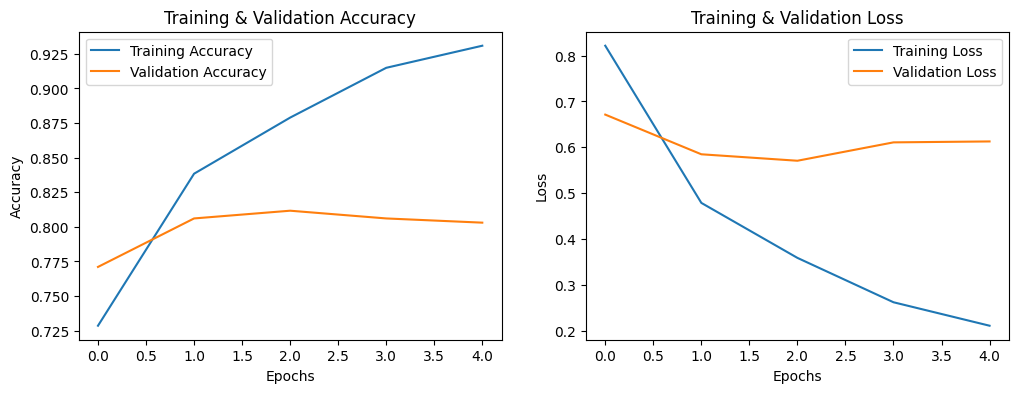

In [53]:
# Visualization of Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

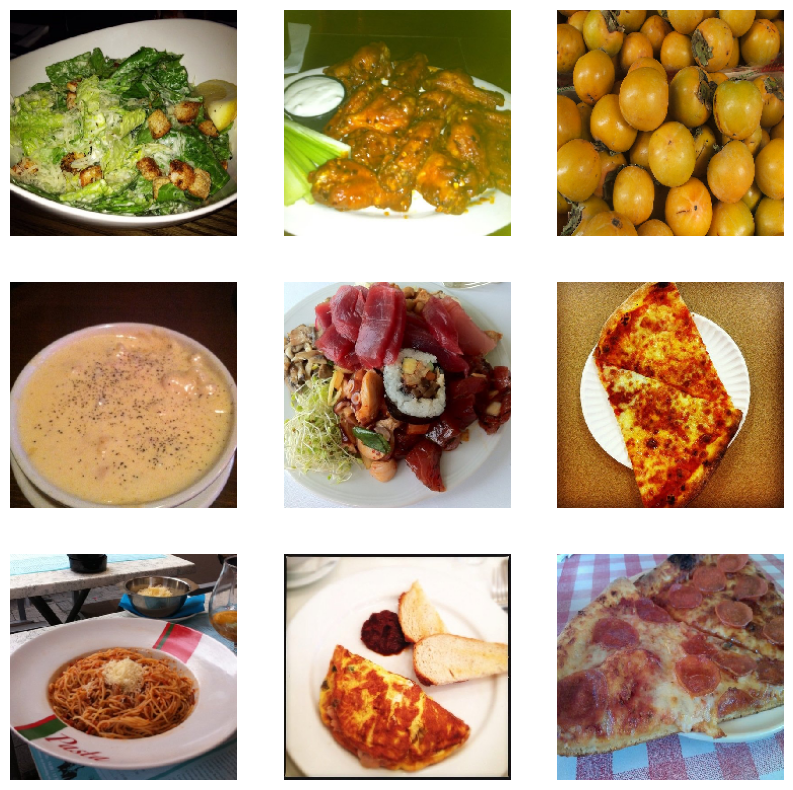

In [54]:
# Visualize some training images
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.show()

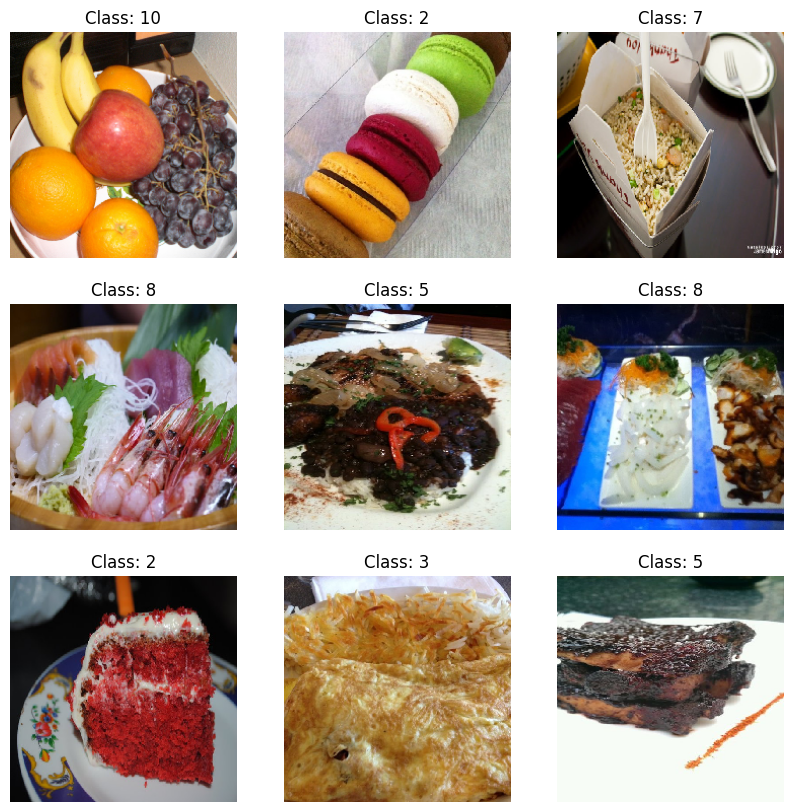

In [58]:
# Visualize some training images with labels
sample_images, sample_labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    # The following lines were not indented properly
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.show()

In [52]:
# Sample Prediction
def predict_food(image_path, model):
    image = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image_array = keras.preprocessing.image.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    predicted_label = np.argmax(predictions)
    return predicted_label